# setup

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time


def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

# prediction

In [2]:
import keras.backend as  K
from keras.models import model_from_json
import skimage.io as io
from model_unet import create_unet

with K.tf.device('/cpu:0'):
    model = create_unet((512, 512, 3), 64, "binarize")
    model.load_weights("./data/2017-04-28-11-11-28_fil64_adam_lr0.0001_glorot_uniform_dice_coef_weights.epoch0081-val_loss-0.75-val_dice_coef0.75.hdf5")
    model2 = create_unet((512, 512, 4), 64, "heatmap")
    model2.load_weights("./data/2017-05-12-06-02-02_fil64_adam_lr0.0001_glorot_uniform_shape256x256_learn_head_data_aug_mean_squared_error_weights.epoch0081-val_loss129.64-val_acc0.71.hdf5")


Using TensorFlow backend.


2.0171422958374023 sec
[[     0      0    512    512 260295]
 [   463    349      8      6     26]
 [   190    358     27     56    901]
 [   237    369     36     21    466]
 [   130    373     23     26    446]
 [   181    399      4      3     10]]


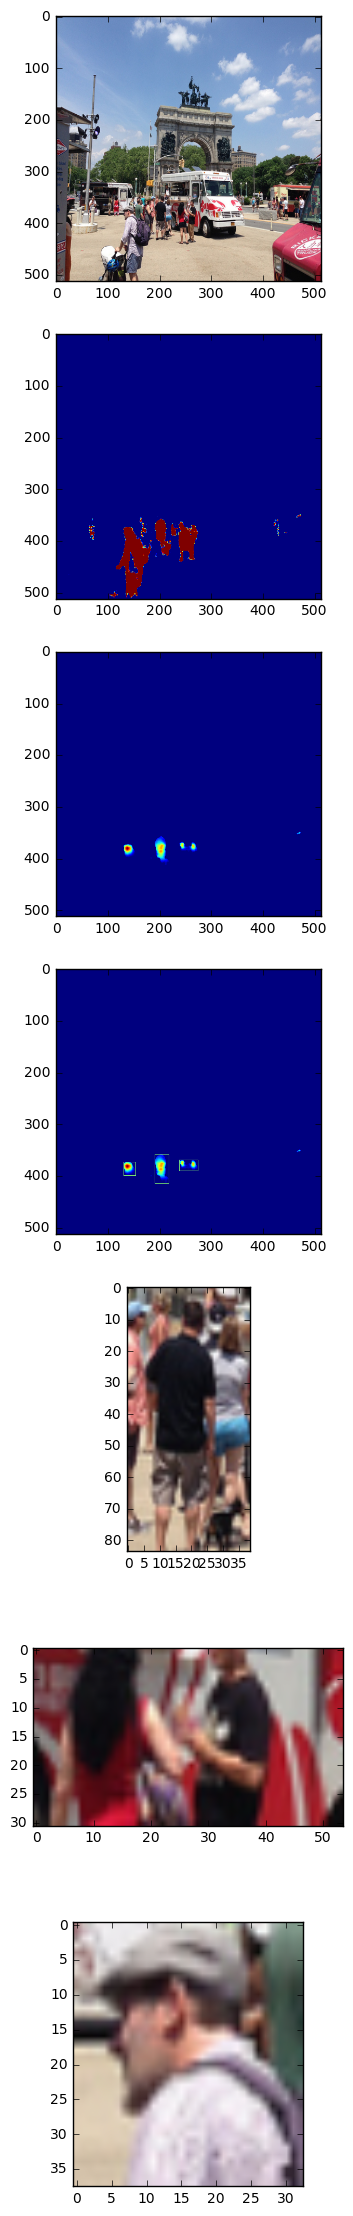

In [83]:
'''
COCO_val2014_000000000589
COCO_val2014_000000000139
COCO_val2014_000000000257
COCO_val2014_000000000283
COCO_val2014_000000000328
COCO_val2014_000000000338
COCO_val2014_000000000357
'''

img = io.imread("./data/val2014/COCO_val2014_000000000257.jpg")
img = cv2.resize(img, (512, 512))
img = np.expand_dims(img, axis=0)


with K.tf.device('/cpu:0'):
        a = time.time()
        output = model.predict(img)
        img2 = np.expand_dims(np.dstack((img[0], output[0])), axis=0)
        output2 = model2.predict(img2)
        b = time.time()
        print(b-a, "sec")

th1 = output2[0].astype("uint8")
labelnum, labelimg, contours, GoCs = cv2.connectedComponentsWithStats(th1)
print(contours)

clips = []
for label in range(labelnum):
    x,y,w,h,size = contours[label]
    if w == 512 and h == 512: continue
    if size < 5*5: continue
    marginX = int(w/4)
    marginY = int(h/4)
    rect = th1[max(0, y-marginY):min(y+h+marginY, 511), max(0, x-marginX):min(x+w+marginX, 511)].max()
    if rect.max() < 170: continue
    clip = img[0][max(0, y-marginY):min(y+h+marginY, 511), max(0, x-marginX):min(x+w+marginX, 511)]
    clips.append(clip)
    th1 = cv2.rectangle(th1, (x,y), (x+w,y+h), (128,128,128), 1)


mat1 = [
    [ lambda x: plt.imshow(img[0]) ], 
    [ lambda x: plt.imshow(output[0]) ],
    [ lambda x: plt.imshow(output2[0]) ],
    [ lambda x: plt.imshow(th1) ],
]

for clip in clips:
    mat1.append([ (lambda img: lambda x: plt.imshow(img))(clip) ])

mtx_plot(mat1, ratio=(4,4))